<a href="https://colab.research.google.com/github/paromasen2058/Project/blob/main/RL_lane_detection_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # import image 
import cv2
from google.colab import files
uploaded = files.upload()


img = cv2.imread('road_image_final.jpg')

Saving road_image_final.jpg to road_image_final.jpg


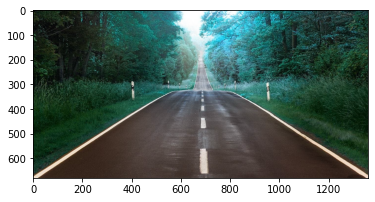

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import ndimage


plt.imshow(img)
plt.show()

In [ ]:
###I.... Image procesing...

#This cell contains all the used functions for Phase I 

#Define RGB2gray function
def rgb2gray(img) :
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])


#Detemine gradient function for Fx and Fy using sobel filter(normlized)
def gradient_x(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
    return grad_img/np.max(grad_img)

def gradient_y(img) :
    grad_img = ndimage.convolve(img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))
    return grad_img/np.max(grad_img)


#Define gradient magnitude function
def gradient_mag(fx, fy) :
    grad_mag = np.hypot(fx, fy)
    return grad_mag/np.max(grad_mag)

In [ ]:
#This cell contains all functions used in Phase 2

#2.a : Find closest direction D*
def closest_dir_function(grad_dir) :
    closest_dir_arr = np.zeros(grad_dir.shape)
    for i in range(1, int(grad_dir.shape[0] - 1)) :
        for j in range(1, int(grad_dir.shape[1] - 1)) :
            
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)) :
                closest_dir_arr[i, j] = 0
                
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)) :
                closest_dir_arr[i, j] = 45
                
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)) : 
                closest_dir_arr[i, j] = 90
                
            else:
                closest_dir_arr[i, j] = 135
                
    return closest_dir_arr


#2.b : Convert to thinned edge
def non_maximal_suppressor(grad_mag, closest_dir) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(closest_dir[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else :
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output/np.max(thinned_output) 

In [ ]:
#This cell contains all the used functionsfor Phase III

#Function to include weak pixels that are connected to chain of strong pixels 
def DFS(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                
                    
#Hysteresis Thresholding
def hysteresis_thresholding(img) :
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)
    
    #Assign values to pixels
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            #Strong pixels
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            #Weak pixels
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            #Intermediate pixels
            else :
                temp_img[i, j] = 1
    
    #Include weak pixels that are connected to chain of strong pixels 
    total_strong = np.sum(temp_img == 2)
    while(1) :
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    #Remove weak pixels
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    

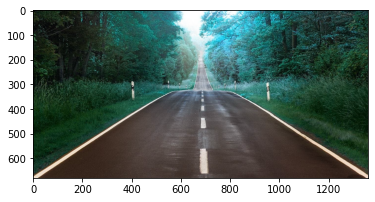

Edge strength of the gray scaled image


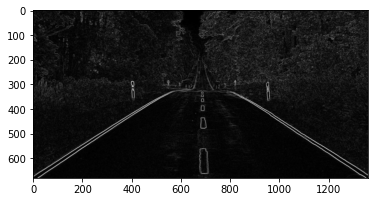

computation of direction of gradient of the gray scaled image


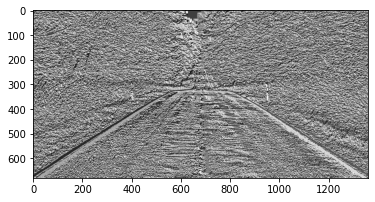

Non maximal suppression


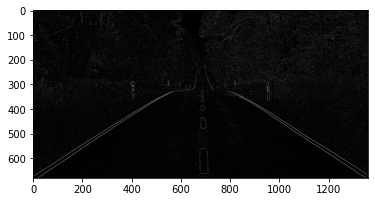

Hysteresis Thesholding of the image


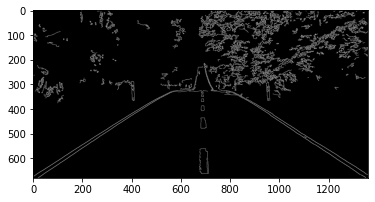

In [ ]:
#Canny Edge Detector Implementation and test



img = cv2.imread('road_image_final.jpg')

#Load the input images

    
plt.imshow(img)
plt.show()


    
#Convert the image to grayscale
gray_input_img = rgb2gray(img)
    
#Apply gaussian blurring
blur_img = ndimage.gaussian_filter(gray_input_img, sigma = 1.0)
    
#Find gradient Fx
x_grad = gradient_x(blur_img)
    
#Find gradient Fy
y_grad = gradient_y(blur_img)

print('Edge strength of the gray scaled image')

#Compute edge strength
grad_mag = gradient_mag(x_grad, y_grad)
plt.imshow(grad_mag, cmap = plt.get_cmap('gray'))
plt.show()
    
print('computation of direction of gradient of the gray scaled image')   
#Compute direction of gradient
grad_dir = np.degrees(np.arctan2(y_grad, x_grad))
plt.imshow(grad_dir, cmap = plt.get_cmap('gray'))
plt.show()
    
print('Non maximal suppression')   
    
#Phase 2 : Non maximal suppression
closest_dir = closest_dir_function(grad_dir)
thinned_output = non_maximal_suppressor(grad_mag, closest_dir)
plt.imshow(thinned_output, cmap = plt.get_cmap('gray'))
plt.show()
    
    
   
print('Hysteresis Thesholding of the image')
#Phase 3 : Hysteresis Thresholding
output_img = hysteresis_thresholding(thinned_output)
plt.imshow(output_img, cmap = plt.get_cmap('gray'))
plt.show()

1360 680
.....Left lane binary image.........


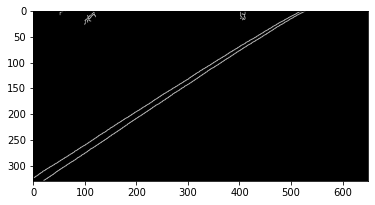

.....Right lane binary image.........


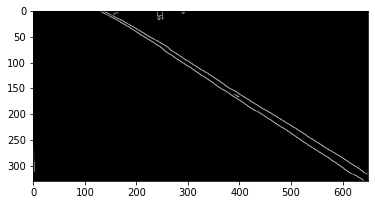

.....Left lane rgb image........


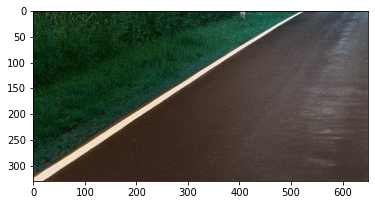

.....Right lane rgb image.........


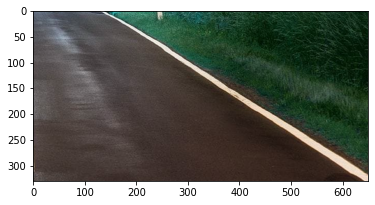

In [ ]:
### II..... Region of Interest ....
## left and right lanes 

####improvise####

# Binary_image
image_width = (output_img.shape[1])
image_height = (output_img.shape[0])

print(image_width, image_height)

print('.....Left lane binary image.........')

left_lane = output_img[350:680, 0:650]
plt.imshow(left_lane, cmap = plt.get_cmap('gray'))
plt.show()

print('.....Right lane binary image.........')

right_lane = output_img[350:680, 710:1360]
plt.imshow(right_lane, cmap = plt.get_cmap('gray'))
plt.show()

#normal image
img_width = (img.shape[1])
img_height = (img.shape[0])

print('.....Left lane rgb image........')

left_lane_img = img[350:680, 0:650]
plt.imshow(left_lane_img, cmap = plt.get_cmap('gray'))
plt.show()

print('.....Right lane rgb image.........')

right_lane_img = img[350:680, 710:1360]
plt.imshow(right_lane_img, cmap = plt.get_cmap('gray'))
plt.show()

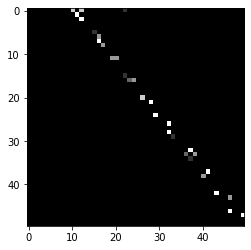

50 50


In [ ]:
# let us consider the right lane at first

import random

image_ht = int(right_lane.shape[0])
image_wt = int(right_lane.shape[1])
# resize due to processing limitations
right_lane_resized_image= cv2.resize(right_lane, (50, 50), interpolation= cv2.INTER_LINEAR)
image_height_binary = int(right_lane_resized_image.shape[0]) # height 
image_width_binary = int(right_lane_resized_image.shape[1]) # width
plt.imshow(right_lane_resized_image, cmap = plt.get_cmap('gray'))
plt.show()

print(image_height_binary, image_width_binary)


In [ ]:
# i is for height and j is for width
x_axis_pixels = []
y_axis_pixels = []

for i in range(image_height_binary):
  for j in range(image_width_binary):
    if (right_lane_resized_image[i, j]== 1.0):
      print(i, j)
      x_axis_pixels.append(j)
      y_axis_pixels.append(i)


# create an array of such points and display them
print(x_axis_pixels)
print(y_axis_pixels)

1 11
2 12
7 16
21 28
24 29
26 32
28 32
32 37
37 41
42 43
46 46
47 49
[11, 12, 16, 28, 29, 32, 32, 37, 41, 43, 46, 49]
[1, 2, 7, 21, 24, 26, 28, 32, 37, 42, 46, 47]


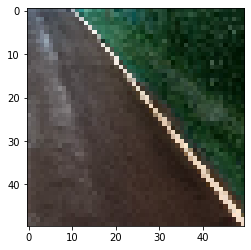

50 50


In [ ]:
image_rgb_ht = int(right_lane_img.shape[0])
image_rgb_wt = int(right_lane_img.shape[1])
# resize due to processing limitations
right_lane_rgb_resized_image= cv2.resize(right_lane_img, (50, 50), interpolation= cv2.INTER_LINEAR)
image_rgb_height_binary = int(right_lane_rgb_resized_image.shape[0]) # height 
image_rgb_width_binary = int(right_lane_rgb_resized_image.shape[1]) # width
plt.imshow(right_lane_rgb_resized_image, cmap = plt.get_cmap('gray'))
plt.show()

print(image_rgb_height_binary, image_rgb_width_binary)

{(0, 0, 0): 0, (0, 0, 1): 0, (0, 0, 2): 0, (0, 0, 3): 0, (0, 1, 0): 0, (0, 1, 1): 0, (0, 1, 2): 0, (0, 1, 3): 0, (0, 2, 0): 0, (0, 2, 1): 0, (0, 2, 2): 0, (0, 2, 3): 0, (0, 3, 0): 0, (0, 3, 1): 0, (0, 3, 2): 0, (0, 3, 3): 0, (0, 4, 0): 0, (0, 4, 1): 0, (0, 4, 2): 0, (0, 4, 3): 0, (0, 5, 0): 0, (0, 5, 1): 0, (0, 5, 2): 0, (0, 5, 3): 0, (0, 6, 0): 0, (0, 6, 1): 0, (0, 6, 2): 0, (0, 6, 3): 0, (0, 7, 0): 0, (0, 7, 1): 0, (0, 7, 2): 0, (0, 7, 3): 0, (0, 8, 0): 0, (0, 8, 1): 0, (0, 8, 2): 0, (0, 8, 3): 0, (0, 9, 0): 0, (0, 9, 1): 0, (0, 9, 2): 0, (0, 9, 3): 0, (0, 10, 0): 0, (0, 10, 1): 0, (0, 10, 2): 0, (0, 10, 3): 0, (0, 11, 0): 0, (0, 11, 1): 0, (0, 11, 2): 0, (0, 11, 3): 0, (0, 12, 0): 0, (0, 12, 1): 0, (0, 12, 2): 0, (0, 12, 3): 0, (0, 13, 0): 0, (0, 13, 1): 0, (0, 13, 2): 0, (0, 13, 3): 0, (0, 14, 0): 0, (0, 14, 1): 0, (0, 14, 2): 0, (0, 14, 3): 0, (0, 15, 0): 0, (0, 15, 1): 0, (0, 15, 2): 0, (0, 15, 3): 0, (0, 16, 0): 0, (0, 16, 1): 0, (0, 16, 2): 0, (0, 16, 3): 0, (0, 17, 0): 0, (0, 

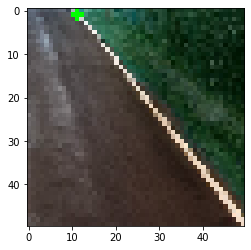

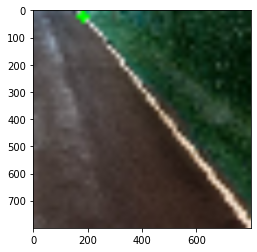

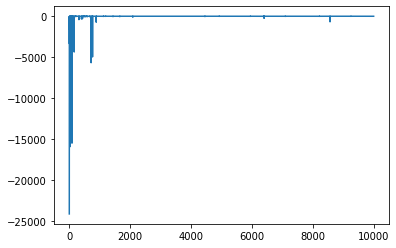

-----------------------------------------------
| -6.889 | -6.544 | -6.889 | -6.734 | -6.488 | -6.247 | -6.031 | -5.873 | -5.657 | -5.538 | -5.464 | -5.269 | -5.276 | -5.185 | -5.051 | -5.079 | -4.825 | -5.009 | -5.039 | -5.056 | -4.92  | -4.866 | -5.009 | -4.866 | -4.823 | -4.842 | -4.835 | -4.78  | -4.596 | -4.74  | -4.715 | -4.866 | -4.866 | -4.902 | -4.889 | -4.852 | -4.82  | -4.737 | -4.604 | -4.607 | -4.514 | -4.551 | -4.596 | -4.753 | -4.525 | -4.312 | -4.312 | -4.226 | -4.184 | -4.253 | 
-----------------------------------------------
| -6.544 | -6.161 | -6.544 | -6.618 | -6.416 | -6.263 | -6.042 | -5.842 | -5.63  | -5.416 | -5.275 | -5.159 | -5.169 | -4.989 | -4.989 | -5.046 | -5.037 | -5.095 | -5.057 | -5.005 | -4.868 | -4.88  | -5.052 | -4.857 | -4.818 | -4.78  | -4.691 | -4.767 | -4.709 | -4.692 | -4.66  | -4.767 | -4.856 | -4.861 | -4.773 | -4.843 | -4.629 | -4.601 | -4.611 | -4.652 | -4.587 | -4.53  | -4.571 | -4.646 | -4.459 | -4.527 | -4.446 | -4.304 | -4.223 | -4.277 |

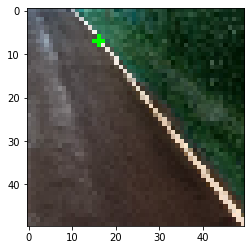

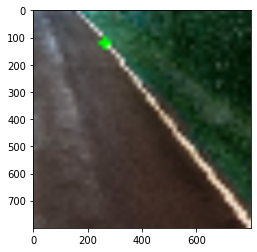

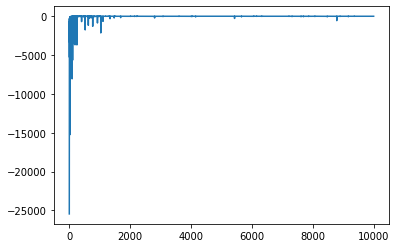

-----------------------------------------------
| -7.536 | -7.588 | -7.65  | -7.814 | -7.965 | -8.095 | -8.161 | -7.957 | -8.161 | -8.129 | -7.987 | -7.875 | -7.694 | -7.558 | -7.399 | -7.322 | -7.141 | -6.988 | -6.851 | -6.899 | -6.765 | -6.765 | -6.751 | -6.575 | -6.579 | -6.558 | -6.485 | -6.481 | -6.454 | -6.191 | -6.062 | -6.028 | -6.041 | -6.019 | -6.028 | -5.963 | -6.028 | -5.949 | -6.079 | -6.053 | -6.016 | -5.946 | -5.959 | -5.901 | -5.765 | -5.635 | -5.713 | -5.691 | -5.709 | -5.854 | 
-----------------------------------------------
| -7.495 | -7.518 | -7.659 | -7.774 | -7.922 | -7.983 | -7.957 | -7.731 | -7.957 | -8.027 | -7.868 | -7.737 | -7.632 | -7.53  | -7.369 | -7.237 | -7.147 | -7.035 | -6.914 | -6.87  | -6.771 | -6.758 | -6.698 | -6.61  | -6.634 | -6.495 | -6.462 | -6.443 | -6.335 | -6.276 | -6.145 | -6.138 | -6.06  | -5.942 | -5.955 | -5.967 | -6.056 | -6.085 | -6.095 | -6.039 | -5.931 | -5.929 | -5.921 | -5.779 | -5.748 | -5.682 | -5.707 | -5.727 | -5.774 | -5.905 |

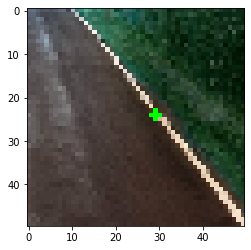

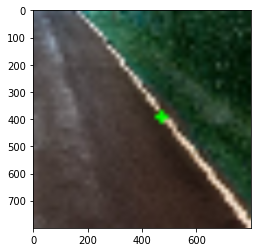

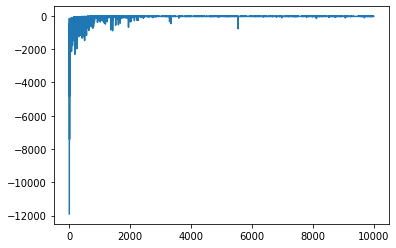

-----------------------------------------------
| -8.836 | -8.835 | -8.879 | -8.898 | -8.89  | -8.85  | -8.852 | -8.886 | -8.941 | -8.945 | -8.955 | -9.013 | -9.045 | -9.077 | -9.142 | -9.182 | -9.236 | -9.284 | -9.322 | -9.353 | -9.406 | -9.458 | -9.502 | -9.529 | -9.477 | -9.529 | -9.496 | -9.445 | -9.399 | -9.352 | -9.305 | -9.257 | -9.198 | -9.176 | -9.102 | -9.069 | -9.005 | -8.964 | -8.926 | -8.909 | -8.871 | -8.851 | -8.838 | -8.816 | -8.816 | -8.802 | -8.756 | -8.707 | -8.754 | -8.812 | 
-----------------------------------------------
| -8.849 | -8.835 | -8.851 | -8.868 | -8.873 | -8.876 | -8.879 | -8.895 | -8.925 | -8.955 | -8.935 | -9.001 | -9.021 | -9.06  | -9.112 | -9.17  | -9.192 | -9.246 | -9.295 | -9.346 | -9.382 | -9.434 | -9.473 | -9.477 | -9.419 | -9.477 | -9.474 | -9.428 | -9.388 | -9.336 | -9.288 | -9.237 | -9.215 | -9.159 | -9.095 | -9.054 | -9.012 | -8.968 | -8.94  | -8.911 | -8.857 | -8.818 | -8.829 | -8.8   | -8.794 | -8.811 | -8.776 | -8.767 | -8.729 | -8.793 |

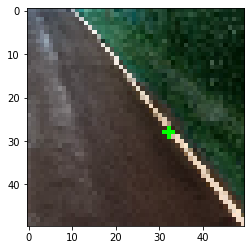

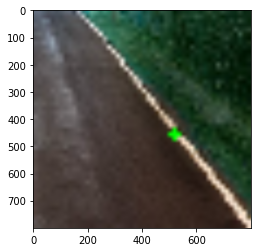

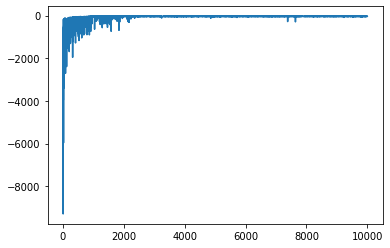

-----------------------------------------------
| -8.968 | -8.935 | -8.909 | -8.958 | -8.991 | -9.011 | -9.02  | -9.034 | -9.062 | -9.032 | -9.052 | -9.09  | -9.103 | -9.143 | -9.203 | -9.229 | -9.258 | -9.28  | -9.315 | -9.368 | -9.413 | -9.447 | -9.491 | -9.532 | -9.558 | -9.596 | -9.63  | -9.656 | -9.618 | -9.656 | -9.632 | -9.6   | -9.558 | -9.518 | -9.473 | -9.443 | -9.402 | -9.369 | -9.339 | -9.302 | -9.255 | -9.219 | -9.183 | -9.17  | -9.148 | -9.12  | -9.1   | -9.133 | -9.142 | -9.103 | 
-----------------------------------------------
| -8.929 | -8.938 | -8.946 | -8.948 | -8.963 | -8.959 | -8.975 | -9.032 | -9.041 | -9.052 | -9.08  | -9.093 | -9.113 | -9.141 | -9.197 | -9.249 | -9.276 | -9.286 | -9.315 | -9.354 | -9.395 | -9.422 | -9.468 | -9.5   | -9.532 | -9.567 | -9.601 | -9.618 | -9.576 | -9.618 | -9.606 | -9.567 | -9.541 | -9.501 | -9.456 | -9.424 | -9.392 | -9.366 | -9.332 | -9.3   | -9.253 | -9.222 | -9.17  | -9.162 | -9.146 | -9.11  | -9.091 | -9.108 | -9.104 | -9.091 |

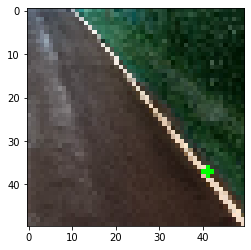

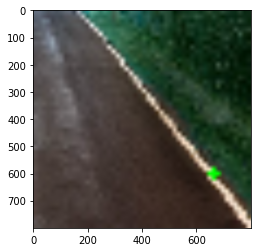

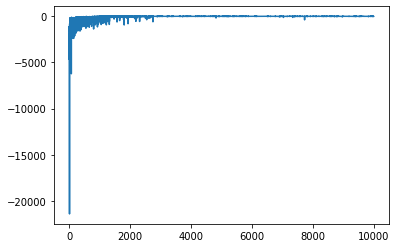

-----------------------------------------------
| -9.393 | -9.412 | -9.416 | -9.422 | -9.423 | -9.432 | -9.441 | -9.424 | -9.446 | -9.433 | -9.45  | -9.458 | -9.474 | -9.497 | -9.513 | -9.512 | -9.533 | -9.551 | -9.565 | -9.583 | -9.592 | -9.606 | -9.623 | -9.647 | -9.672 | -9.685 | -9.708 | -9.722 | -9.742 | -9.76  | -9.778 | -9.79  | -9.808 | -9.822 | -9.837 | -9.853 | -9.864 | -9.849 | -9.864 | -9.858 | -9.845 | -9.834 | -9.82  | -9.806 | -9.793 | -9.785 | -9.771 | -9.765 | -9.763 | -9.767 | 
-----------------------------------------------
| -9.41  | -9.417 | -9.424 | -9.421 | -9.422 | -9.428 | -9.438 | -9.418 | -9.441 | -9.435 | -9.447 | -9.463 | -9.481 | -9.504 | -9.51  | -9.513 | -9.535 | -9.545 | -9.567 | -9.579 | -9.589 | -9.611 | -9.627 | -9.647 | -9.668 | -9.681 | -9.693 | -9.72  | -9.737 | -9.75  | -9.766 | -9.785 | -9.801 | -9.814 | -9.828 | -9.843 | -9.849 | -9.833 | -9.849 | -9.85  | -9.837 | -9.824 | -9.813 | -9.797 | -9.791 | -9.779 | -9.767 | -9.763 | -9.761 | -9.761 |

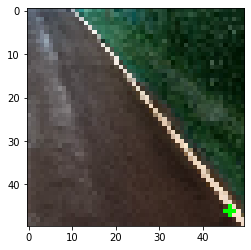

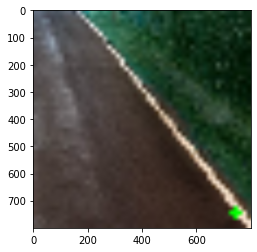

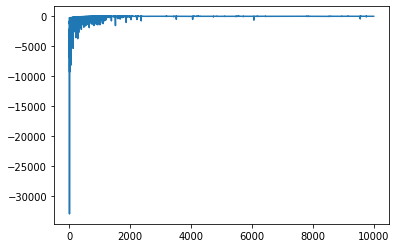

-----------------------------------------------
| -9.57  | -9.573 | -9.58  | -9.587 | -9.577 | -9.59  | -9.586 | -9.579 | -9.579 | -9.576 | -9.59  | -9.603 | -9.609 | -9.627 | -9.625 | -9.629 | -9.638 | -9.64  | -9.656 | -9.667 | -9.673 | -9.69  | -9.697 | -9.704 | -9.71  | -9.717 | -9.725 | -9.733 | -9.747 | -9.756 | -9.766 | -9.779 | -9.783 | -9.798 | -9.807 | -9.816 | -9.827 | -9.838 | -9.852 | -9.864 | -9.874 | -9.883 | -9.894 | -9.903 | -9.911 | -9.918 | -9.91  | -9.918 | -9.918 | -9.913 | 
-----------------------------------------------
| -9.582 | -9.569 | -9.574 | -9.577 | -9.576 | -9.576 | -9.568 | -9.585 | -9.585 | -9.594 | -9.604 | -9.606 | -9.605 | -9.623 | -9.622 | -9.639 | -9.637 | -9.64  | -9.647 | -9.653 | -9.67  | -9.68  | -9.692 | -9.697 | -9.701 | -9.708 | -9.714 | -9.728 | -9.737 | -9.746 | -9.763 | -9.773 | -9.781 | -9.797 | -9.806 | -9.813 | -9.824 | -9.838 | -9.846 | -9.856 | -9.867 | -9.878 | -9.888 | -9.897 | -9.904 | -9.91  | -9.9   | -9.91  | -9.913 | -9.91  |

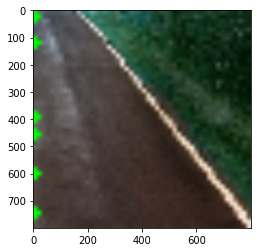

***************** Final Image output **********************


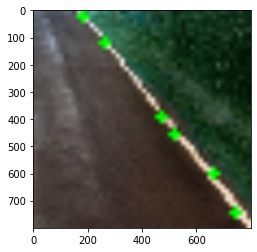

In [ ]:

# III.... Q learning Implementation

BOARD_ROWS = image_width_binary     #### 10
BOARD_COLS = image_height_binary     #### 10 previously now 50

#class state defines the board and decides reward, end and next position
class State:

    def __init__(self, state, winstate):
        

        #initalise the state to start and end to false
        self.state = state
        self.win_state = winstate

        self.isEnd = False        

    def getReward(self):
        #give the rewards for each state -5 for loss, +1 for win, -1 for others

        
        if self.state == self.win_state:
            return 1       
        
        else:
            return -1 

        
    
    
        


    def isEndFunc(self):
        #set state to end if win state
        if (self.state == self.win_state):
            self.isEnd = True


    def nxtPosition(self, action):     
        #set the positions from current action - up, down, left, right
        if action == 0:                
            nxtState = (self.state[0] - 1, self.state[1]) #up             
        elif action == 1:
            nxtState = (self.state[0] + 1, self.state[1]) #down
        elif action == 2:
            nxtState = (self.state[0], self.state[1] - 1) #left
        else:
            nxtState = (self.state[0], self.state[1] + 1) #right


        #check if next state is possible
        if (nxtState[0] >= 0) and (nxtState[0] <= 49):   ###changed value
            if (nxtState[1] >= 0) and (nxtState[1] <= 49):   ####changed value 
                    #if possible change to next state                
                    return nxtState 

        #Return current state if outside grid     
        return self.state 



        
#class agent to implement reinforcement learning through grid  
class Agent:

    def __init__(self, start_state, end_state):
        #inialise states and actions 
        self.states = []
        self.actions = [0,1,2,3]    # up, down, left, right
        self.start_state = start_state
        self.end_state = end_state
                
        self.State = State(self.start_state, self.end_state)
        #set the learning and greedy values
        self.alpha = 0.5
        self.gamma = 0.9
        self.epsilon = 0.1
        self.isEnd = self.State.isEnd
        
        

        # array to retain reward values for plot
        self.plot_reward = []
        
        #initalise Q values as a dictionary for current and new
        self.Q = {}
        self.new_Q = {}
        #initalise rewards to 0
        self.rewards = 0
        
        #initalise all Q values across the board to 0, print these values
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(len(self.actions)):
                    self.Q[(i, j, k)] =0
                    self.new_Q[(i, j, k)] = 0
        
        print(self.Q)
        
    

    #method to choose action with Epsilon greedy policy, and move to next state
    def Action(self):
        #random value vs epsilon
        rnd = random.random()
        #set arbitraty low value to compare with Q values to find max
        mx_nxt_reward =-10
        action = None
        
        #9/10 find max Q value over actions 
        if(rnd >self.epsilon) :
            #iterate through actions, find Q  value and choose best 
            for k in self.actions:
                
                i,j = self.State.state
                
                nxt_reward = self.Q[(i,j, k)]
                
                if nxt_reward >= mx_nxt_reward:
                    action = k
                    mx_nxt_reward = nxt_reward
                    
        #else choose random action
        else:
            action = np.random.choice(self.actions)
        
        #select the next state based on action chosen
        position = self.State.nxtPosition(action)
        return position,action
    
    
    #Q-learning Algorithm
    def Q_Learning(self,episodes):
        x = 0
        #iterate through best path for each episode
        while(x < episodes):
            #check if state is end
            if self.isEnd:
                #get current rewrard and add to array for plot
                reward = self.State.getReward()
                self.rewards += reward
                self.plot_reward.append(self.rewards)
                
                #get state, assign reward to each Q_value in state
                i,j = self.State.state
                for a in self.actions:
                    self.new_Q[(i,j,a)] = round(reward,3)
                    
                #reset state
                self.State = State(self.start_state, self.end_state)
                self.isEnd = self.State.isEnd
                
                #set rewards to zero and iterate to next episode
                self.rewards = 0
                x+=1
            else:
                #set to arbitrary low value to compare net state actions
                mx_nxt_value = -10
                #get current state, next state, action and current reward
                next_state, action = self.Action()
                i,j = self.State.state
                reward = self.State.getReward()
                #add reward to rewards for plot
                self.rewards +=reward
                
                #iterate through actions to find max Q value for action based on next state action
                for a in self.actions:
                    nxtStateAction = (next_state[0], next_state[1], a)
                    q_value = (1-self.alpha)*self.Q[(i,j,action)] + self.alpha*(reward + self.gamma*self.Q[nxtStateAction])
                
                    #find largest Q value
                    if q_value >= mx_nxt_value:
                        mx_nxt_value = q_value
                
                #next state is now current state, check if end state
                self.State = State(state=next_state, winstate = self.end_state)
                self.State.isEndFunc()
                self.isEnd = self.State.isEnd
                
                #update Q values with max Q value for next state
                self.new_Q[(i,j,action)] = round(mx_nxt_value,3)
            
            #copy new Q values to Q table
            self.Q = self.new_Q.copy()
        #print final Q table output
        print(self.Q)
        ####added####
        self.showVisual(i,j)

        
    #plot the reward vs episodes
    def plot(self,episodes):
        
        plt.plot(self.plot_reward)
        plt.show()
        
        
    #iterate through the board and find largest Q value in each, print output
    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('-----------------------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                mx_nxt_value = -10
                for a in self.actions:
                    nxt_value = self.Q[(i,j,a)]
                    if nxt_value >= mx_nxt_value:
                        mx_nxt_value = nxt_value
                out += str(mx_nxt_value).ljust(6) + ' | '
            print(out)
        print('-----------------------------------------------')


    def showVisual(self, x, y):
          
      img_clone = np.copy(right_lane_rgb_resized_image)
      cv2.circle(img_clone, (x, y), 0, (0,255,0), thickness=2)  # reduce thickness to 1
      #resize it back just for the visual
      image_resized= cv2.resize(img_clone, (800, 800), interpolation= cv2.INTER_LINEAR)
      plt.imshow(img_clone)
      plt.show()

      plt.imshow(image_resized)
      plt.show()

      cv2.circle(img_processed, (x, y), 0, (0,255,0), thickness=2)

      

        
    
        
if __name__ == "__main__":
    #create agent for 10,000 episdoes implementing a Q-learning algorithm plot and show values.
    img_initial_image = np.copy(right_lane_rgb_resized_image)
    img_processed = np.copy(right_lane_rgb_resized_image)


    ### build instances #######
    ag1= Agent((0, y_axis_pixels[0]), (x_axis_pixels[0], y_axis_pixels[0]))
    ag2 = Agent((0, y_axis_pixels[2]), (x_axis_pixels[2], y_axis_pixels[2]))
    ag3 = Agent((0, y_axis_pixels[4]), (x_axis_pixels[4], y_axis_pixels[4]))
    ag4 = Agent((0, y_axis_pixels[6]), (x_axis_pixels[6], y_axis_pixels[6]))
    ag5 = Agent((0, y_axis_pixels[8]), (x_axis_pixels[8], y_axis_pixels[8]))
    ag6 = Agent((0, y_axis_pixels[10]), (x_axis_pixels[10], y_axis_pixels[10]))
    
    

    episodes = 10000
    Show_Every = 1000

    ag1.Q_Learning(episodes)
    ag1.plot(episodes)
    ag1.showValues()

    ag2.Q_Learning(episodes)
    ag2.plot(episodes)
    ag2.showValues()

    ag3.Q_Learning(episodes)
    ag3.plot(episodes)
    ag3.showValues()

    ag4.Q_Learning(episodes)
    ag4.plot(episodes)
    ag4.showValues()

    ag5.Q_Learning(episodes)
    ag5.plot(episodes)
    ag5.showValues()

    ag6.Q_Learning(episodes)
    ag6.plot(episodes)
    ag6.showValues()



    print('***************** Initial Image output **********************')

    #Initial image 
    cv2.circle(img_initial_image, (0, y_axis_pixels[0]), 0, (0,255,0), thickness=2)
    cv2.circle(img_initial_image, (0, y_axis_pixels[2]), 0, (0,255,0), thickness=2)
    cv2.circle(img_initial_image, (0, y_axis_pixels[4]), 0, (0,255,0), thickness=2)
    cv2.circle(img_initial_image, (0, y_axis_pixels[6]), 0, (0,255,0), thickness=2)
    cv2.circle(img_initial_image, (0, y_axis_pixels[8]), 0, (0,255,0), thickness=2)
    cv2.circle(img_initial_image, (0, y_axis_pixels[10]), 0, (0,255,0), thickness=2)
    Initial_image_resized = cv2.resize(img_initial_image, (800, 800), interpolation= cv2.INTER_LINEAR)
    plt.imshow(Initial_image_resized)
    plt.show()

    print('***************** Final Image output **********************')


    # final processed image 
    Final_image_resized= cv2.resize(img_processed, (800, 800), interpolation= cv2.INTER_LINEAR)
    plt.imshow(Final_image_resized)
    plt.show()

